In [ ]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab,lab2rgb
import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset,DataLoader

In [ ]:
from torchvision import datasets
print("Loading CIFAR-10 dataset...")
train_dataset_full=datasets.CIFAR10(
    root="./data",
    train=True,
    download=True
)
val_dataset_full=datasets.CIFAR10(
    root="./data",
    train=False,
    download=True
)
# CIFAR-10 already has:
#   50,000 training images
#   10,000 test/validation images
print("Train size:",len(train_dataset_full))
print("Val size:",len(val_dataset_full))

Loading CIFAR-10 dataset...


100%|██████████| 170M/170M [00:06<00:00, 25.0MB/s]


Train size: 50000
Val size: 10000


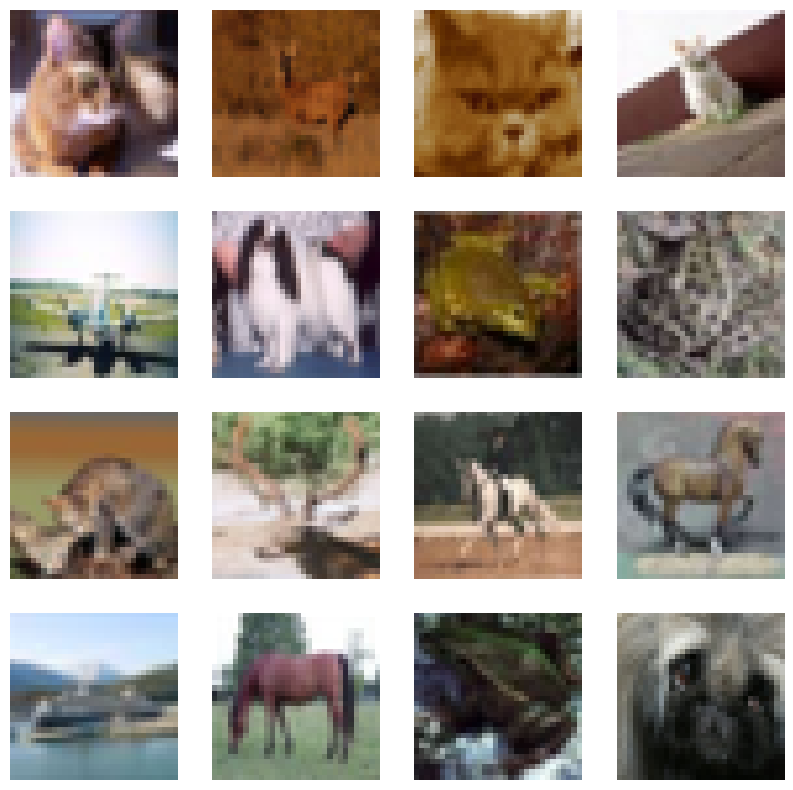

In [ ]:
_,axes=plt.subplots(4,4,figsize=(10,10))

for ax in axes.flatten():
    img,_=train_dataset_full[np.random.randint(len(train_dataset_full))]
    ax.imshow(img)
    ax.axis("off")


In [ ]:
SIZE=256

class ColorizationDataset(Dataset):
    def __init__(self,train=True):
        # load CIFAR-10 dataset
        self.dataset=datasets.CIFAR10(root="./data",train=train,download=True)

        # transforms (resize + flip)
        if train:
            self.transforms=transforms.Compose([
                transforms.Resize((SIZE,SIZE),Image.BICUBIC),
                transforms.RandomHorizontalFlip(),
            ])
        else:
            self.transforms=transforms.Resize((SIZE,SIZE),Image.BICUBIC)

    def __getitem__(self,idx):
        # CIFAR-10 returns (PIL_image, label)
        img,_=self.dataset[idx]
        img=self.transforms(img)
        img=np.array(img)

        # convert to LAB
        img_lab=rgb2lab(img).astype("float32")
        img_lab=transforms.ToTensor()(img_lab)

        # normalize to -1 to 1
        L=img_lab[[0],...]/50.-1.
        ab=img_lab[[1,2],...]/110.

        return{"L":L,"ab":ab}

    def __len__(self):
        return len(self.dataset)


In [ ]:
def make_dataloaders(batch_size=16,n_workers=4,pin_memory=True,train=True):
    dataset=ColorizationDataset(train=train)
    dataloader=DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=n_workers,
        pin_memory=pin_memory,
        shuffle=train,
    )
    return dataloader


In [ ]:
train_dl=make_dataloaders(train=True)
val_dl=make_dataloaders(train=False)
data=next(iter(train_dl))
Ls,abs_=data["L"],data["ab"]
print(Ls.shape,abs_.shape)
print(len(train_dl),len(val_dl))


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
3125 625


In [ ]:
class UnetBlock(nn.Module):
    def __init__(self,nf,ni,submodule=None,input_c=None,dropout=False,innermost=False,outermost=False):
        super().__init__()
        self.outermost=outermost
        if input_c is None: input_c=nf
        downconv=nn.Conv2d(input_c,ni,kernel_size=4,stride=2,padding=1,bias=False)
        downrelu=nn.LeakyReLU(0.2,True)
        downnorm=nn.BatchNorm2d(ni)
        uprelu=nn.ReLU(True)
        upnorm=nn.BatchNorm2d(nf)

        if outermost:
            upconv=nn.ConvTranspose2d(ni*2,nf,kernel_size=4,stride=2,padding=1)
            down=[downconv]
            up=[uprelu,upconv,nn.Tanh()]
            model=down+[submodule]+up
        elif innermost:
            upconv=nn.ConvTranspose2d(ni,nf,kernel_size=4,stride=2,padding=1,bias=False)
            down=[downrelu,downconv]
            up=[uprelu,upconv,upnorm]
            model=down+up
        else:
            upconv=nn.ConvTranspose2d(ni*2,nf,kernel_size=4,stride=2,padding=1,bias=False)
            down=[downrelu,downconv,downnorm]
            up=[uprelu,upconv,upnorm]
            if dropout: up+=[nn.Dropout(0.5)]
            model=down+[submodule]+up
        self.model=nn.Sequential(*model)

    def forward(self,x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x,self.model(x)],1)

class Unet(nn.Module):
    def __init__(self,input_c=1,output_c=2,n_down=8,num_filters=64):
        super().__init__()
        unet_block=UnetBlock(num_filters*8,num_filters*8,innermost=True)
        for _ in range(n_down-5):
            unet_block=UnetBlock(num_filters*8,num_filters*8,submodule=unet_block,dropout=True)
        out_filters=num_filters*8
        for _ in range(3):
            unet_block=UnetBlock(out_filters//2,out_filters,submodule=unet_block)
            out_filters//=2
        self.model=UnetBlock(output_c,out_filters,input_c=input_c,submodule=unet_block,outermost=True)

    def forward(self,x):
        return self.model(x)


In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self,input_c,num_filters=64,n_down=3):
        super().__init__()
        model=[self.get_layers(input_c,num_filters,norm=False)]
        model+=[self.get_layers(num_filters*2**i,num_filters*2**(i+1),s=1 if i==(n_down-1) else 2) for i in range(n_down)]
        model+=[self.get_layers(num_filters*2**n_down,1,s=1,norm=False,act=False)]
        self.model=nn.Sequential(*model)

    def get_layers(self,ni,nf,k=4,s=2,p=1,norm=True,act=True):
        layers=[nn.Conv2d(ni,nf,k,s,p,bias=not norm)]
        if norm: layers+=[nn.BatchNorm2d(nf)]
        if act: layers+=[nn.LeakyReLU(0.2,True)]
        return nn.Sequential(*layers)

    def forward(self,x):
        return self.model(x)


In [ ]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [ ]:
discriminator=PatchDiscriminator(3)
dummy_input=torch.randn(16,3,256,256)
out=discriminator(dummy_input)
out.shape


torch.Size([16, 1, 30, 30])

In [ ]:
class GANLoss(nn.Module):
    def __init__(self,gan_mode="vanilla",real_label=1.0,fake_label=0.0):
        super().__init__()
        self.register_buffer("real_label",torch.tensor(real_label))
        self.register_buffer("fake_label",torch.tensor(fake_label))
        if gan_mode=="vanilla":
            self.loss=nn.BCEWithLogitsLoss()
        elif gan_mode=="lsgan":
            self.loss=nn.MSELoss()
    def get_labels(self,preds,target_is_real):
        if target_is_real:
            labels=self.real_label
        else:
            labels=self.fake_label
        return labels.expand_as(preds)
    def __call__(self,preds,target_is_real):
        labels=self.get_labels(preds,target_is_real)
        loss=self.loss(preds,labels)
        return loss


In [ ]:
def init_weights(net,init="norm",gain=0.02):
    def init_func(m):
        classname=m.__class__.__name__
        if hasattr(m,"weight") and "Conv" in classname:
            if init=="norm":
                nn.init.normal_(m.weight.data,mean=0.0,std=gain)
            elif init=="xavier":
                nn.init.xavier_normal_(m.weight.data,gain=gain)
            elif init=="kaiming":
                nn.init.kaiming_normal_(m.weight.data,a=0,mode="fan_in")
            if hasattr(m,"bias") and m.bias is not None:
                nn.init.constant_(m.bias.data,0.0)
        elif "BatchNorm2d" in classname:
            nn.init.normal_(m.weight.data,1.,gain)
            nn.init.constant_(m.bias.data,0.)
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model,device):
    model=model.to(device)
    model=init_weights(model)
    return model

In [ ]:
class MainModel(nn.Module):
    def __init__(self,net_G=None,lr_G=2e-4,lr_D=2e-4,beta1=0.5,beta2=0.999,lambda_L1=100.):
        super().__init__()
        self.device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1=lambda_L1
        if net_G is None:
            self.net_G=init_model(Unet(input_c=1,output_c=2,n_down=8,num_filters=64),self.device)
        else:
            self.net_G=net_G.to(self.device)
        self.net_D=init_model(PatchDiscriminator(input_c=3,n_down=3,num_filters=64),self.device)
        self.GANcriterion=GANLoss(gan_mode="vanilla").to(self.device)
        self.L1criterion=nn.L1Loss()
        self.opt_G=optim.Adam(self.net_G.parameters(),lr=lr_G,betas=(beta1,beta2))
        self.opt_D=optim.Adam(self.net_D.parameters(),lr=lr_D,betas=(beta1,beta2))

    def set_requires_grad(self,model,requires_grad=True):
        for p in model.parameters():
            p.requires_grad=requires_grad

    def setup_input(self,data):
        self.L=data["L"].to(self.device)
        self.ab=data["ab"].to(self.device)

    def forward(self):
        self.fake_color=self.net_G(self.L)

    def backward_D(self):
        fake_image=torch.cat([self.L,self.fake_color],dim=1)
        fake_preds=self.net_D(fake_image.detach())
        self.loss_D_fake=self.GANcriterion(fake_preds,False)
        real_image=torch.cat([self.L,self.ab],dim=1)
        real_preds=self.net_D(real_image)
        self.loss_D_real=self.GANcriterion(real_preds,True)
        self.loss_D=(self.loss_D_fake+self.loss_D_real)*0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image=torch.cat([self.L,self.fake_color],dim=1)
        fake_preds=self.net_D(fake_image)
        self.loss_G_GAN=self.GANcriterion(fake_preds,True)
        self.loss_G_L1=self.L1criterion(self.fake_color,self.ab)*self.lambda_L1
        self.loss_G=self.loss_G_GAN+self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D,True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        self.net_G.train()
        self.set_requires_grad(self.net_D,False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()


In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count,self.avg,self.sum=[0.]*3

    def update(self,val,count=1):
        self.count+=count
        self.sum+=count*val
        self.avg=self.sum/self.count

def create_loss_meters():
    loss_D_fake=AverageMeter()
    loss_D_real=AverageMeter()
    loss_D=AverageMeter()
    loss_G_GAN=AverageMeter()
    loss_G_L1=AverageMeter()
    loss_G=AverageMeter()
    return{
        "loss_D_fake":loss_D_fake,
        "loss_D_real":loss_D_real,
        "loss_D":loss_D,
        "loss_G_GAN":loss_G_GAN,
        "loss_G_L1":loss_G_L1,
        "loss_G":loss_G
    }

def update_losses(model,loss_meter_dict,count):
    for loss_name,loss_meter in loss_meter_dict.items():
        loss=getattr(model,loss_name)
        loss_meter.update(loss.item(),count=count)

def lab_to_rgb(L,ab):
    L=(L+1.)*50.
    ab=ab*110.
    Lab=torch.cat([L,ab],dim=1).permute(0,2,3,1).cpu().numpy()
    rgb_imgs=[]
    for img in Lab:
        img_rgb=lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs,axis=0)

def visualize(model,data,save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color=model.fake_color.detach()
    real_color=model.ab
    L=model.L
    fake_imgs=lab_to_rgb(L,fake_color)
    real_imgs=lab_to_rgb(L,real_color)
    fig=plt.figure(figsize=(15,8))
    for i in range(5):
        ax=plt.subplot(3,5,i+1)
        ax.imshow(L[i][0].cpu(),cmap="gray")
        ax.axis("off")
        ax=plt.subplot(3,5,i+1+5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax=plt.subplot(3,5,i+1+10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

def log_results(loss_meter_dict):
    for loss_name,loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")


In [ ]:
def train_model(model,train_dl,val_dl,epochs,display_every=200):
    data=next(iter(val_dl))
    for e in range(epochs):
        loss_meter_dict=create_loss_meters()
        i=0
        for data in tqdm(train_dl):
            model.setup_input(data)
            model.optimize()
            update_losses(model,loss_meter_dict,count=data["L"].size(0))
            i+=1
            if i%display_every==0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict)
                visualize(model,data,save=False)

model=MainModel()
train_model(model,train_dl,val_dl,epochs=10)
